#Weather Classification
this classification contains five diffrent classes

#Importing libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Creating File Structure
splitting data in train test and validation folders

In [3]:
import os
from glob import glob


data_path = '/content/drive/MyDrive/Colab Notebooks/dataset'

#list of all image paths and labels
image_paths = []
labels = []
categories = ['cloudy', 'rainy', 'foggy', 'shine', 'sunrise']

for category in categories:
    category_path = os.path.join(data_path, category)
    for img_path in glob(os.path.join(category_path, '*.jpg')):
        image_paths.append(img_path)
        labels.append(category)


In [4]:
from sklearn.model_selection import train_test_split

# First split into train+validation and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Further split train and validation into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42)


In [5]:
import shutil

# Create new directories for training, validation, and test sets
base_dir = '/content/drive/MyDrive/split_dataset'
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

# Function to move files to the new directory structure
def move_files(file_paths, labels, split):
    for file_path, label in zip(file_paths, labels):
        dest_dir = os.path.join(base_dir, split, label)
        shutil.copy(file_path, dest_dir)

# Move the files
move_files(train_paths, train_labels, 'train')
move_files(val_paths, val_labels, 'val')
move_files(test_paths, test_labels, 'test')


#Checking File Structure

In [6]:
import tensorflow as tf

# Define the paths to your dataset
train_dir = '/content/drive/MyDrive/split_dataset/train'
val_dir = '/content/drive/MyDrive/split_dataset/val'
test_dir = '/content/drive/MyDrive/split_dataset/test'

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)


Found 885 files belonging to 5 classes.
Found 295 files belonging to 5 classes.
Found 296 files belonging to 5 classes.


#Loading image in GBR format using opencv

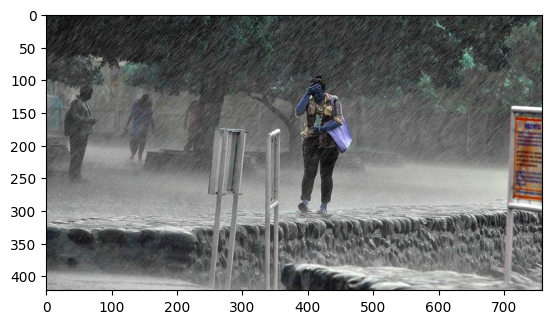

In [28]:
shine= cv2.imread('/content/drive/MyDrive/split_dataset/train/rainy/rain11.jpg')
plt.imshow(shine)

#Converting image from BGR to RGB

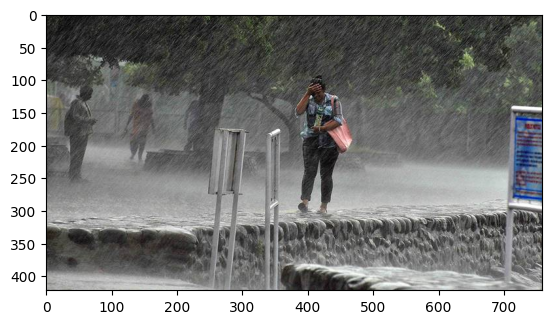

In [29]:
shine_rgb=cv2.cvtColor(shine,cv2.COLOR_BGR2RGB)
plt.imshow(shine_rgb)

#Checking image shape and dtype

In [30]:
print(shine.shape)

(422, 759, 3)


#Image Augmentation

In [31]:
from keras.preprocessing.image import ImageDataGenerator
image_gen=ImageDataGenerator(rotation_range=20,width_shift_range=0.1,rescale=1/255,height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

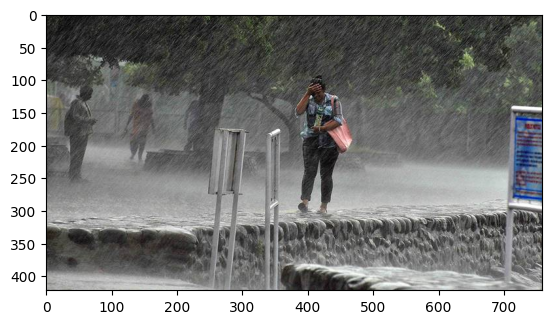

In [32]:
plt.imshow(shine_rgb)

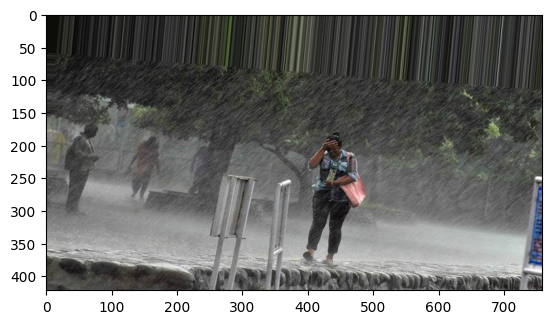

In [33]:
plt.imshow(image_gen.random_transform(shine_rgb))

# Now Making Directory Flow

In [34]:
image_gen.flow_from_directory(train_dir)

Found 885 images belonging to 5 classes.


In [35]:
image_gen.flow_from_directory(test_dir)

Found 296 images belonging to 5 classes.


In [36]:
image_gen.flow_from_directory(val_dir)

Found 295 images belonging to 5 classes.


In [37]:
image_shape=(224,224,3)

#Transfer Learning VGG19

In [38]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

In [39]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
train_image_gen= image_gen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode='categorical')

Found 885 images belonging to 5 classes.


In [41]:
test_image_gen= image_gen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                              batch_size=64,
                                              class_mode='categorical'
                                             )

Found 296 images belonging to 5 classes.


In [42]:
val_image_gen= image_gen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                              batch_size=64,
                                              class_mode='categorical'
                                             )

Found 296 images belonging to 5 classes.


In [43]:
# Train the model
model.fit(train_image_gen, validation_data=test_image_gen,verbose=1,epochs=2)



Epoch 1/2
56/56 [==============================] - 27s 462ms/step - loss: 1.1122 - accuracy: 0.5864 - val_loss: 0.6037 - val_accuracy: 0.7838
Epoch 2/2
56/56 [==============================] - 23s 404ms/step - loss: 0.4829 - accuracy: 0.8237 - val_loss: 0.8099 - val_accuracy: 0.7432


#Evaluating the model

In [44]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_image_gen)
print(f"Test Accuracy: {test_accuracy}")

5/5 [==============================] - 7s 1s/step - loss: 0.8254 - accuracy: 0.7264
Test Accuracy: 0.7263513803482056


In [45]:
model.evaluate_generator(test_image_gen)

<ipython-input-45-31acfd80dad9>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_image_gen)


[0.8867669105529785, 0.712837815284729]

In [46]:
from sklearn.metrics import classification_report

# Get true labels and predictions for test set
test_image_gen.reset()  # Reset generator to start fetching from the beginning
num_test_samples = len(test_image_gen.filenames)
test_steps = np.ceil(num_test_samples / test_image_gen.batch_size)

predictions = model.predict_generator(test_image_gen, steps=test_steps, verbose=1)
y_true = test_image_gen.classes
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)


<ipython-input-46-e4fe904114e2>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_image_gen, steps=test_steps, verbose=1)


5/5 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

           0       0.14      0.13      0.14        60
           1       0.21      0.12      0.15        57
           2       0.23      0.25      0.24        59
           3       0.19      0.06      0.09        50
           4       0.23      0.41      0.30        70

    accuracy                           0.21       296
   macro avg       0.20      0.20      0.18       296
weighted avg       0.20      0.21      0.19       296

